1. Data Preparation

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Download historical data from Yahoo Finance
data = yf.download(['^NZ50', '^GSPC', '^AXJO'], start='2010-01-01', end='2024-01-01')
data = data['Adj Close']  # We use the adjusted closing prices
data.dropna(inplace=True)  # Handle missing values
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,^AXJO,^GSPC,^NZ50
Date,,,
2010-01-05 00:00:00+00:00,4924.299805,1136.520020,3268.189941
2010-01-06 00:00:00+00:00,4921.399902,1137.140015,3271.570068
2010-01-07 00:00:00+00:00,4899.399902,1141.689941,3284.810059
2010-01-08 00:00:00+00:00,4912.100098,1144.979980,3310.229980
2010-01-11 00:00:00+00:00,4950.700195,1146.979980,3303.750000


2. Feature Engineering

In [2]:
# Calculate percentage changes
data['NZX_Change'] = data['^NZ50'].pct_change()
data['SP500_Change'] = data['^GSPC'].pct_change()
data['ASX200_Change'] = data['^AXJO'].pct_change()

# Create the target variable based on whether NZX 50 goes up or down
data['Direction'] = (data['NZX_Change'] > 0).astype(int)
data.dropna(inplace=True)
data.head()


Ticker,^AXJO,^GSPC,^NZ50,NZX_Change,SP500_Change,ASX200_Change,Direction
Date,,,,,,,
2010-01-06 00:00:00+00:00,4921.399902,1137.140015,3271.570068,0.001034,0.000546,-0.000589,1
2010-01-07 00:00:00+00:00,4899.399902,1141.689941,3284.810059,0.004047,0.004001,-0.004470,1
2010-01-08 00:00:00+00:00,4912.100098,1144.979980,3310.229980,0.007739,0.002882,0.002592,1
2010-01-11 00:00:00+00:00,4950.700195,1146.979980,3303.750000,-0.001958,0.001747,0.007858,0
2010-01-12 00:00:00+00:00,4899.500000,1136.219971,3290.290039,-0.004074,-0.009381,-0.010342,0


3. Splitting Data for Training and Testing

In [3]:
# Features: S&P500 and ASX200 percentage changes
X = data[['SP500_Change', 'ASX200_Change']]
y = data['Direction']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4. Model Building: Logistic Regression

In [4]:
# Build the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)


5. Model Evaluation

Accuracy: 0.5619335347432024
Confusion Matrix:
[[  3 290]
 [  0 369]]


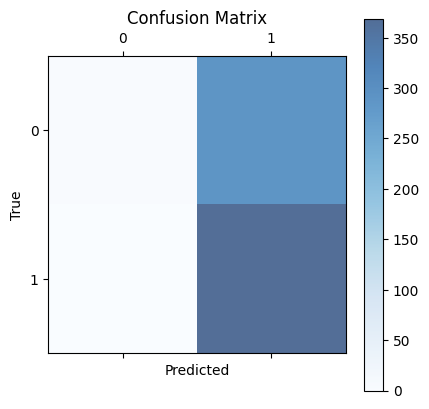

In [5]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


6. Multiple Inputs and Features

In [6]:
# Add lagged features (previous day percentage changes)
data['SP500_Lag'] = data['SP500_Change'].shift(1)
data['ASX200_Lag'] = data['ASX200_Change'].shift(1)
data.dropna(inplace=True)

# Features with lagged values
X = data[['SP500_Change', 'ASX200_Change', 'SP500_Lag', 'ASX200_Lag']]
y = data['Direction']

# Split the data again with the new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model again
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with lagged features: {accuracy}")


Accuracy with lagged features: 0.5694864048338368


7. Prediction with New Inputs

In [8]:
# New data for prediction
new_data = pd.DataFrame({
    'SP500_Change': [0.005],  # Example: +0.5% S&P500 change
    'ASX200_Change': [0.003],  # Example: +0.3% ASX200 change
    'SP500_Lag': [0.004],      # Previous day S&P500 change
    'ASX200_Lag': [0.002]      # Previous day ASX200 change
})

# Make predictions for the new data
new_prediction = model.predict(new_data)
print(f"Prediction for new data: {'Up' if new_prediction[0] == 1 else 'Down'}")


Prediction for new data: Up
